In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set()

Skip to [Observations and Discussion](#discussion)

- **'NGS-punt_return.csv'** is obtained from: https://www.kaggle.com/jdemeo/preprocessing-ngs
- **'play-punt_return-yardage.csv'** is obtained from: https://www.kaggle.com/jdemeo/preprocessing-punt-play

In [66]:
# Load in NGS data, player role data, and play info
ngs_df = pd.read_csv('data/NGS-punt_return.csv')
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')
play_df = pd.read_csv('data/play-punt_return-yardage.csv')

# Merge datasets
ngs_df = pd.merge(ngs_df, play_player_role_df,
                  how="inner",
                  on=['GameKey', 'PlayID', 'GSISID'])

ngs_df = pd.merge(ngs_df, play_df,
                  how="inner",
                  on=['GameKey', 'PlayID'])

# Cleanup
droppers = ['count']
ngs_df.drop(columns=droppers, inplace=True)
ngs_df.head()

,GameKey,PlayID,GSISID,Time,x,y,dis,Event,Season_Year,Role,PlayDescription,yardage on play,reward
0,3,455,31762.0,2016-08-11 23:50:54.300,40.450001,30.99,0.01,NaN,2016,PLG,(6:44) (Punt formation) S.Koch punts 54 yards ...,9,0.104651
1,3,455,31762.0,2016-08-11 23:50:54.400,40.450001,30.99,0.00,NaN,2016,PLG,(6:44) (Punt formation) S.Koch punts 54 yards ...,9,0.104651
2,3,455,31762.0,2016-08-11 23:50:54.500,40.450001,30.99,0.00,NaN,2016,PLG,(6:44) (Punt formation) S.Koch punts 54 yards ...,9,0.104651
3,3,455,31762.0,2016-08-11 23:50:54.600,40.459999,30.98,0.02,NaN,2016,PLG,(6:44) (Punt formation) S.Koch punts 54 yards ...,9,0.104651
4,3,455,31762.0,2016-08-11 23:50:54.700,40.470001,30.98,0.01,NaN,2016,PLG,(6:44) (Punt formation) S.Koch punts 54 yards ...,9,0.104651


In [67]:
# NGS Unique_ids
ngs_ids = ngs_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
ngs_ids.shape

(2623, 3)

### Goal: Understand the proximity of the nearest punt player to the PR when the punt is caught by the PR
This is done in hopes to understand what the impact of having a restricted zone for a PR would be on the 2016 and 2017 punt returns. I am primarily interested in seeing how much return yardage is being lost if certain plays were negated as a result of the rule to better assess the penalty yardage amount for infringing on a PR restricted zone. This analysis is also done to understand how many plays would be negated by such a rule just in general and have reasoning for a particular restricted zone distance.

In [68]:
'''ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'''

# def isolate_play(df, game_key, play_id):
#     '''Create a dataframe of a particular play'''
#     where_condition = ((df['GameKey'] == game_key) &
#                        (df['PlayID'] == play_id))
#     new_df = df[where_condition].copy()
#     new_df.sort_values(by=['Time'], inplace=True)
#     new_df.reset_index(drop=True, inplace=True)
#     return new_df

# def course_of_events(df):
#     '''Get list of events in order of occurrence for a particular play'''
#     events = []
#     for i in range(len(df)):
#         event = df.loc[i, 'Event']
#         if event not in events:
#             events.append(event)
           
#     print('Play Description:', df.loc[0, 'PlayDescription'])
#     print('---')
#     print('Game Events:', events)
#     print('-----------------------------------------------')

'ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'

In [69]:
# # Iterate through ids to get events for each play
# for i in range(len(ngs_ids)):
#     game_key = ngs_ids.loc[i, 'GameKey']
#     play_id = ngs_ids.loc[i, 'PlayID']
#     the_play = isolate_play(ngs_df, game_key, play_id)
#     course_of_events(the_play)

- Looking at the course of events during a play, 'punt_received' seems like a reasonable place to see proximity of oponnent players

In [70]:
def event_df_creation(df, event):
    '''Get a new dataframe with data pertinent to a particular event'''
    new_df = df[df['Event'] == event].reset_index(drop=True)
    unique_ids = new_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
    return new_df, unique_ids

In [71]:
# Let's indicate what team the player is playing on based off player role
return_team_positions = ['PR', 'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDR1', 'PDR2', 'PDR3', 'PDR4', 'VL', 'VR', 
                         'PLL', 'PLR', 'VRo', 'VRi', 'VLi', 'VLo', 'PLM', 'PLR1', 'PLR2', 'PLL1', 'PLL2',
                         'PFB', 'PDL5', 'PDR5', 'PDL6', 'PLR3', 'PLL3', 'PDR6', 'PLM1', 'PDM']
punt_team_positions = ['P', 'PLS', 'PPR', 'PLG', 'PRG', 'PLT', 'PRT', 'PLW', 'PRW', 'GL', 'GR',
                       'GRo', 'GRi', 'GLi', 'GLo', 'PC', 'PPRo', 'PPRi', 'PPL', 'PPLi', 'PPLo']

def label_team(df):
    '''Label each player by the team they play on'''
    df['team'] = ''
    print('Determining player roles')

    for i, role in enumerate(df['Role']):
        if role in return_team_positions:
            df.loc[i, 'team'] = 'return team'
        elif role in punt_team_positions:
            df.loc[i, 'team'] = 'punt team'
        else:
            df.loc[i, 'team'] = 'unknown'

In [72]:
def calculate_player_proximity(role_x, role_y, player_x, player_y):
    '''Calculate euclidean distance between two players'''
    leg_x = (role_x - player_x) ** 2
    leg_y = (role_y - player_y) ** 2
    hypotenuse = np.sqrt(leg_x + leg_y)
    return hypotenuse

In [73]:
def calculate_x_proximity(role_x, player_x):
    '''Calculate distance of a player to a particular role only by yardline'''
    return np.abs(role_x - player_x)

In [74]:
def calculate_proximity_for_play(df, unique_ids, role):
    '''Calculate proximity of each player to the player of a particular role'''
    # Create feature for player proximity
    df['proximity_to_' + role + '_circle'] = 0
    df['proximity_to_' + role + '_x'] = 0
    
    print('Calculating player proximities to', role)
    
    # Go through each data point in particular NGS dataset
    for i in range(len(df)):
        
        # Play Information
        game_key = df.loc[i, 'GameKey']
        play_id = df.loc[i, 'PlayID']
        
        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id))
        just_view = df[where_condition].reset_index()
        
        # Get coordinates of a player with a particular role
        if any(just_view['Role'] == role):
            role_x = just_view.loc[just_view['Role'] == role, 'x'].values[0]
            role_y = just_view.loc[just_view['Role'] == role, 'y'].values[0]
            
        # Plays that don't actually have the particular role represented
        else:
            continue

        # Current Player coordinates
        position_x = df.loc[i, 'x']
        position_y = df.loc[i, 'y']

        # Calculate proximity
        proximity_hypo = calculate_player_proximity(role_x, role_y, position_x, position_y)
        proximity_x = calculate_x_proximity(role_x, position_x)
        df.loc[i, 'proximity_to_' + role + '_circle'] = proximity_hypo
        df.loc[i, 'proximity_to_' + role + '_x'] = proximity_x

In [75]:
def calculate_closest_player(df, unique_ids, column):
    '''Find who the closest player on the punt team is and create new id set'''
    unique_ids[column] = 0
    good_indexes = []
    role = 'PR'
    print('Determining closest player to', role)
    
    for i in range(len(unique_ids)):
        
        # Play information
        game_key = unique_ids.loc[i, 'GameKey']
        play_id = unique_ids.loc[i, 'PlayID']

        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id) &\
                           (df['team'] == 'punt team'))
        just_view = df[where_condition].reset_index(drop=True)
        
        # Take minimum of series and Error handling where the NGS data had no punt team :(
        try:
            unique_ids.loc[i, column] = min(just_view[column])
            good_indexes.append(i)
        except ValueError:
            continue
    
    # Create new set of ids
    new_ids = unique_ids.loc[good_indexes, :].copy()
    new_ids.reset_index(inplace=True, drop=True)
    
    return new_ids

### Goal: Want to look at the closest punt player's proximity when the ball is caught by the PR
- Workflow:
    - Get datapoints for a particular plays event
    - Label the players by what team they are
    - Calculate each players proximity to a particular role
    - Find the minimum distance from punt player to PR
    - Return those proximities for each play
- **PR-proximity.csv** is used in notebook: https://www.kaggle.com/jdemeo/analysis-fair-catches

In [108]:
event_df, event_ids = event_df_creation(ngs_df, 'punt_received')
label_team(event_df)
calculate_proximity_for_play(event_df, event_ids, 'PR')
new_ids = calculate_closest_player(event_df, event_ids, 'proximity_to_PR_circle')
new_ids = calculate_closest_player(event_df, new_ids, 'proximity_to_PR_x')
new_ids.to_csv('data/PR-proximity.csv', index=False)

Determining player roles
Calculating player proximities to PR
Determining closest player to PR
Determining closest player to PR


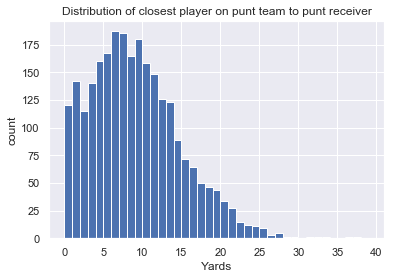

count    2604.000000
mean        9.160595
std         5.734666
min         0.000000
25%         4.860001
50%         8.545000
75%        12.730000
max        37.650002
Name: proximity_to_PR_x, dtype: float64

In [77]:
'''Plot of distribution distance of closest punt team player to punt receiver'''
bins = [i for i in range(0, 40, 1)]
plt.hist(new_ids['proximity_to_PR_x'], bins=bins)

plt.title('Distribution of closest player on punt team to punt receiver')
plt.xlabel('Yards')
plt.ylabel('count')
plt.show()

new_ids['proximity_to_PR_x'].describe()

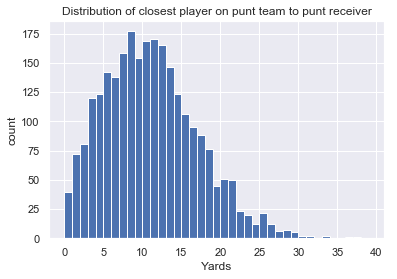

count    2604.000000
mean       11.042307
std         5.990872
min         0.000000
25%         6.546536
50%        10.543427
75%        14.690251
max        37.681484
Name: proximity_to_PR_circle, dtype: float64

In [78]:
'''Plot of distribution distance of closest punt team player to punt receiver'''
bins = [i for i in range(0, 40, 1)]
plt.hist(new_ids['proximity_to_PR_circle'], bins=bins)

plt.title('Distribution of closest player on punt team to punt receiver')
plt.xlabel('Yards')
plt.ylabel('count')
plt.show()

new_ids['proximity_to_PR_circle'].describe()

## <a id="discussion">Observations and Discussion</a>
- Average of the closest punt team player to the PR by yardline distance: 9.17 yards
- Average of the closest punt team player to the PR by Euclidean distance: 11.04 yards
- This can be considered relative to fair catches (https://www.kaggle.com/jdemeo/analysis-fair-catches) in which:
    - Average of the closest punt team player to the by PR yardline distance: 2.72 yards
    - Average of the closest punt team player to the by PR Euclidean distance: 4.04 yards
- We'll now look at the differences in distribution in yards returned on a play as well as the reward of the return to get a better idea of at what distance from the PR are there diminishing returns with regards to having a larger restricted zone
- Part of this analysis is to show why I chose a restricted zone of 8 yards by yardline or 10 yards by euclidean distance.

In [79]:
# Combine yardage data and proximity data
yard_and_proximity = pd.merge(new_ids, play_df,
                          how='inner',
                          on=['GameKey', 'PlayID'])
print(yard_and_proximity.shape)
yard_and_proximity.head()

(2604, 8)


,GameKey,PlayID,count,proximity_to_PR_circle,proximity_to_PR_x,PlayDescription,yardage on play,reward
0,3,455,22,7.248727,7.120003,(6:44) (Punt formation) S.Koch punts 54 yards ...,9,0.104651
1,3,1542,21,1.998125,0.730001,(2:54) (Punt formation) S.Koch punts 45 yards ...,-1,-0.012658
2,4,927,22,5.117831,4.889999,"(1:53) A.Lee punts 40 yards to GB 27, Center-C...",1,0.013699
3,4,1725,20,16.594451,15.660004,"(2:48) A.Lee punts 66 yards to GB 15, Center-C...",5,0.058824
4,4,2888,22,13.772817,12.639999,"(3:29) T.Masthay punts 43 yards to GB 44, Cent...",24,0.428571


### Let's Look at Yardage/Reward and Proximity
- We'll look at the yardage gained on the return and the reward of the play given a certain distance threshold from the PR
- The intuition would likely be that the further the closest punt team player is from the PR the more yardage on average the PR will gain on the return.
- I'm interested in this because if a restricted zone type rule were implemented, I would like to know how many punt plays over the two seasons this rule would have affected and also gauge what is being lost in value for that particular play in both yardage or by a proportional reward metric (yards gained / yards needed to gain for a touchdown)

In [80]:
def build_that_histogram(x, title):
    bins = [i for i in range(min(x), max(x), 1)]
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel('Yards Gained on Return')
    plt.ylabel('Count')
    plt.show()
    
def build_that_histogram_rewards(x, title):
    bins = [i * 0.01 for i in range(-15, 100, 1)]
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel('Reward')
    plt.ylabel('Count')
    plt.show()
    
def distributions_of_interest(yard_and_proximity, proximity_col, dependent_col):
    '''Look at distributions based on proximity with regards to return yardage or reward'''
    mean_dif = []
    for i in range(1, 16):

        # Check for cases less than or equal to a certain distance
        where_condition = yard_and_proximity[proximity_col] <= i
        x = yard_and_proximity[where_condition][dependent_col]
        title = proximity_col + ' <= ' + str(i) + ' yards'
        if dependent_col == 'reward':
            build_that_histogram_rewards(x, title)
        else:
            build_that_histogram(x, title)
        print(x.describe())
        mean1 = x.describe()[1]

        # Check for cases greater than a certain distance
        where_condition = yard_and_proximity[proximity_col] > i
        x = yard_and_proximity[where_condition][dependent_col]
        title = proximity_col + ' > ' + str(i) + ' yards'
        if dependent_col == 'reward':
            build_that_histogram_rewards(x, title)
        else:
            build_that_histogram(x, title)
        print(x.describe())
        mean2 = x.describe()[1]

        mean_dif.append(mean2 - mean1)
        print('-----------------------------------------------')
    
    return mean_dif

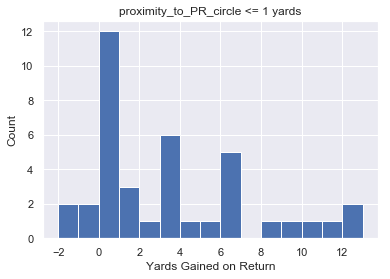

count    40.000000
mean      3.350000
std       4.365071
min      -2.000000
25%       0.000000
50%       2.500000
75%       6.000000
max      14.000000
Name: yardage on play, dtype: float64


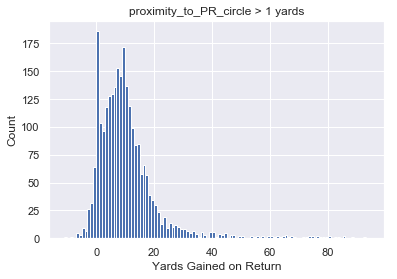

count    2564.000000
mean       10.083073
std        11.478445
min       -11.000000
25%         3.000000
50%         8.000000
75%        13.000000
max        95.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


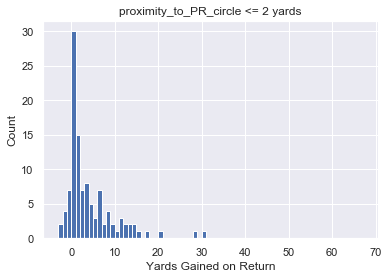

count    112.000000
mean       4.214286
std        8.378897
min       -3.000000
25%        0.000000
50%        1.000000
75%        6.000000
max       68.000000
Name: yardage on play, dtype: float64


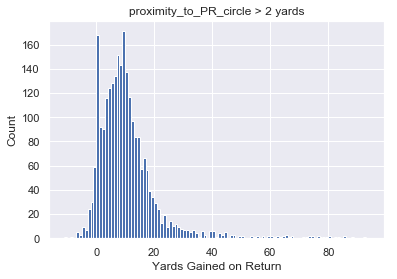

count    2492.000000
mean       10.238764
std        11.484249
min       -11.000000
25%         4.000000
50%         8.000000
75%        13.000000
max        95.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


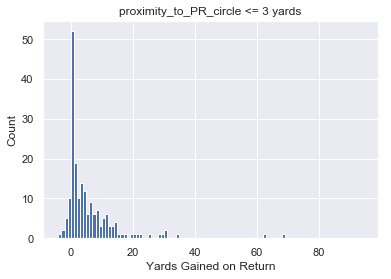

count    193.000000
mean       5.626943
std       11.155422
min       -4.000000
25%        0.000000
50%        2.000000
75%        7.000000
max       95.000000
Name: yardage on play, dtype: float64


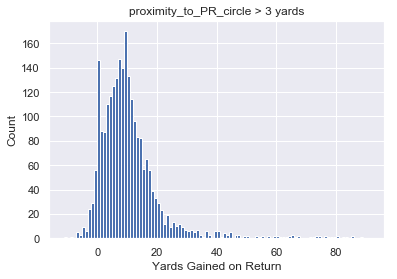

count    2411.000000
mean       10.328080
std        11.384883
min       -11.000000
25%         4.000000
50%         8.000000
75%        13.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


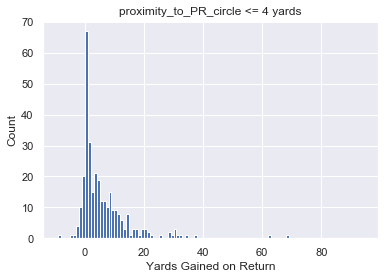

count    313.000000
mean       5.769968
std       10.074950
min       -9.000000
25%        0.000000
50%        3.000000
75%        8.000000
max       95.000000
Name: yardage on play, dtype: float64


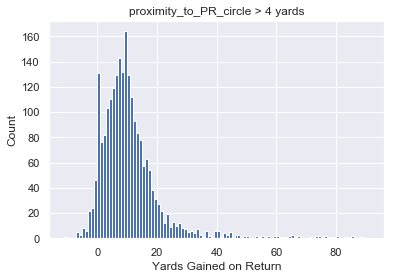

count    2291.000000
mean       10.554780
std        11.488401
min       -11.000000
25%         4.000000
50%         9.000000
75%        13.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


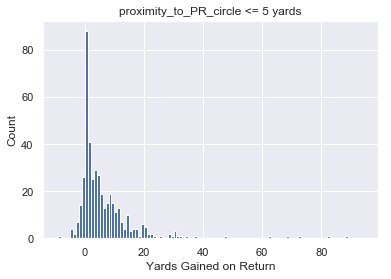

count    436.000000
mean       6.041284
std       11.247197
min       -9.000000
25%        0.000000
50%        3.000000
75%        8.000000
max       95.000000
Name: yardage on play, dtype: float64


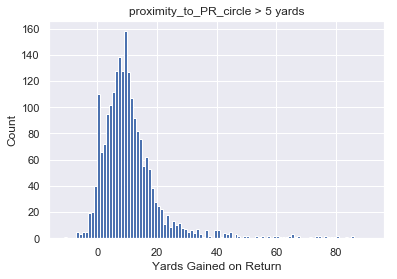

count    2168.000000
mean       10.771679
std        11.307384
min       -11.000000
25%         4.000000
50%         9.000000
75%        14.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


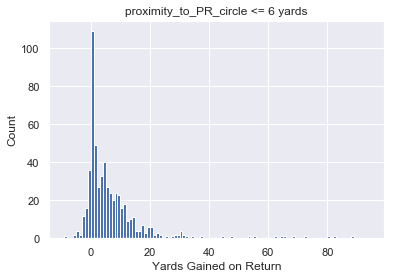

count    578.000000
mean       6.553633
std       11.774663
min       -9.000000
25%        0.000000
50%        3.000000
75%        9.000000
max       95.000000
Name: yardage on play, dtype: float64


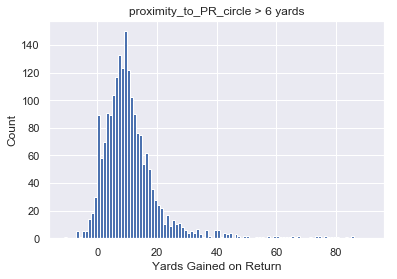

count    2026.000000
mean       10.957058
std        11.144378
min       -11.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


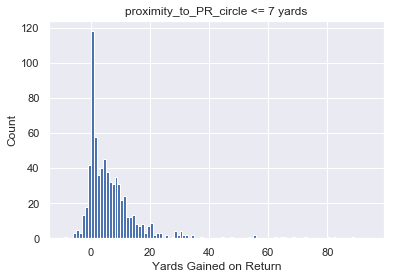

count    716.000000
mean       6.722067
std       11.165863
min       -9.000000
25%        0.000000
50%        4.000000
75%        9.000000
max       95.000000
Name: yardage on play, dtype: float64


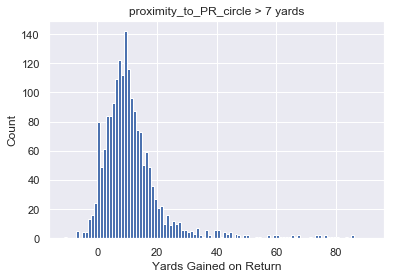

count    1888.000000
mean       11.215042
std        11.291594
min       -11.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


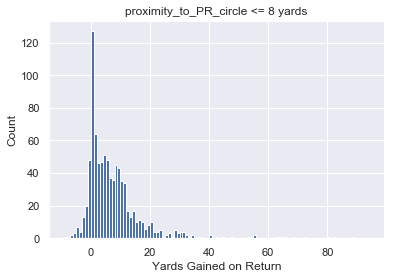

count    874.000000
mean       7.270023
std       11.131530
min       -9.000000
25%        0.000000
50%        5.000000
75%       10.000000
max       95.000000
Name: yardage on play, dtype: float64


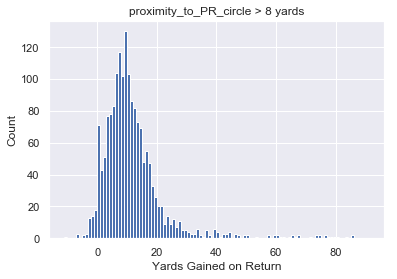

count    1730.000000
mean       11.348555
std        11.341046
min       -11.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


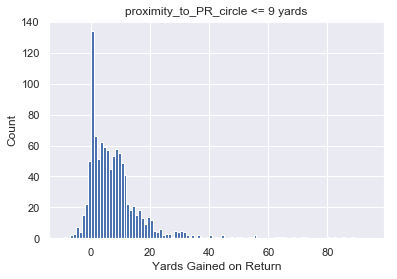

count    1051.000000
mean        7.848716
std        11.204291
min        -9.000000
25%         1.000000
50%         5.000000
75%        10.000000
max        95.000000
Name: yardage on play, dtype: float64


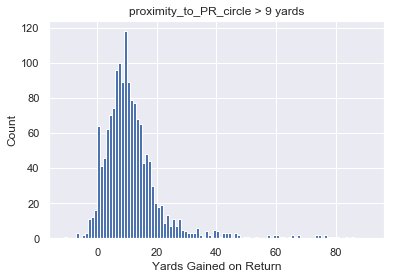

count    1553.000000
mean       11.421764
std        11.363283
min       -11.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


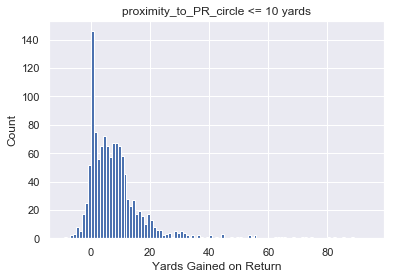

count    1205.000000
mean        7.907884
std        10.977203
min        -9.000000
25%         1.000000
50%         6.000000
75%        10.000000
max        95.000000
Name: yardage on play, dtype: float64


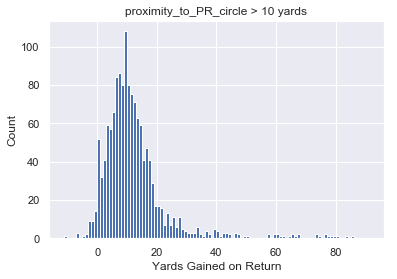

count    1399.000000
mean       11.764117
std        11.519349
min       -11.000000
25%         6.000000
50%         9.000000
75%        14.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


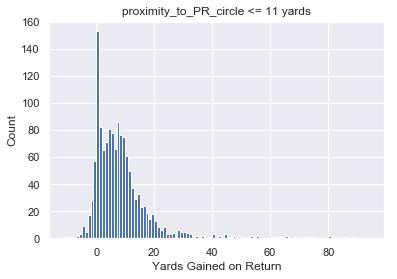

count    1374.000000
mean        8.152111
std        11.069377
min       -11.000000
25%         1.000000
50%         6.000000
75%        11.000000
max        95.000000
Name: yardage on play, dtype: float64


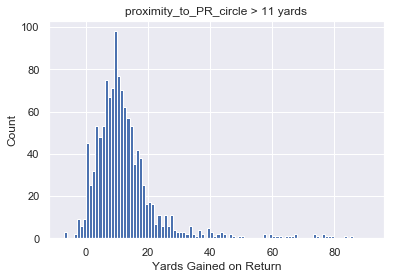

count    1230.000000
mean       12.021138
std        11.490451
min        -7.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


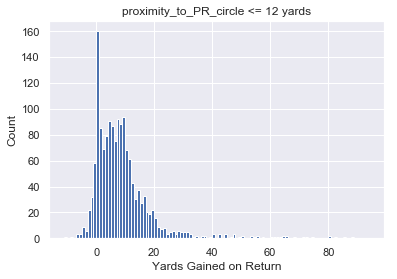

count    1544.000000
mean        8.430052
std        11.091105
min       -11.000000
25%         2.000000
50%         6.000000
75%        11.000000
max        95.000000
Name: yardage on play, dtype: float64


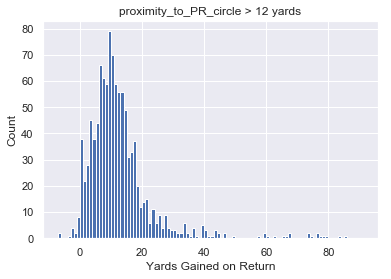

count    1060.000000
mean       12.236792
std        11.551076
min        -7.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


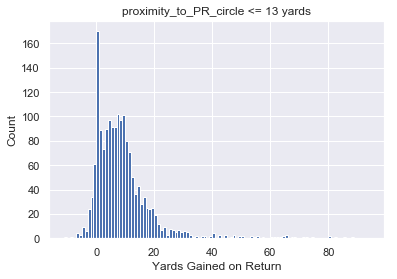

count    1709.000000
mean        8.627267
std        11.039464
min       -11.000000
25%         2.000000
50%         7.000000
75%        11.000000
max        95.000000
Name: yardage on play, dtype: float64


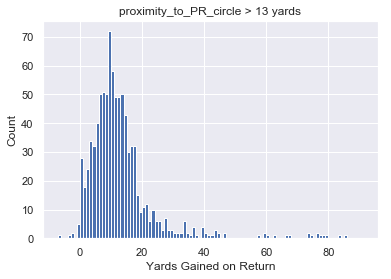

count    895.000000
mean      12.562011
std       11.728105
min       -7.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


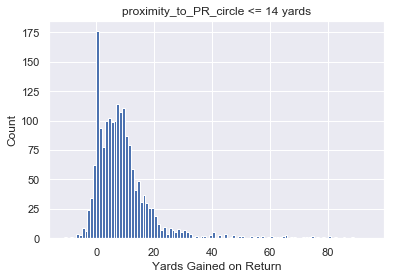

count    1855.000000
mean        8.930458
std        11.414095
min       -11.000000
25%         2.000000
50%         7.000000
75%        11.500000
max        95.000000
Name: yardage on play, dtype: float64


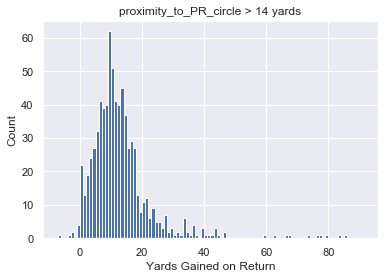

count    749.000000
mean      12.578104
std       11.064630
min       -7.000000
25%        7.000000
50%       10.000000
75%       15.000000
max       92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


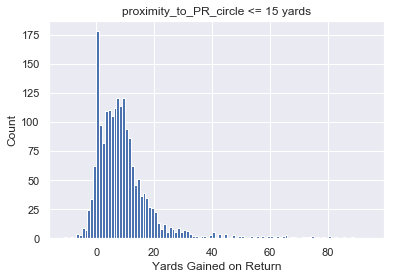

count    1978.000000
mean        9.056623
std        11.327552
min       -11.000000
25%         2.000000
50%         7.000000
75%        12.000000
max        95.000000
Name: yardage on play, dtype: float64


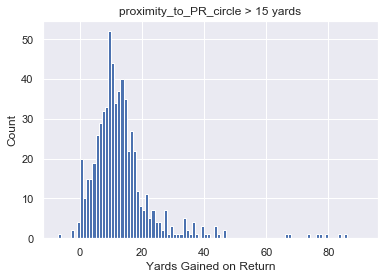

count    626.000000
mean      12.896166
std       11.280443
min       -7.000000
25%        7.000000
50%       11.000000
75%       15.000000
max       92.000000
Name: yardage on play, dtype: float64
-----------------------------------------------


In [97]:
# Try proximity_to_PR_circle' or 'proximity_to_PR_x' as the filter
# Try reward' or 'yardage on play' to see counts of that variable
mean_dif = distributions_of_interest(yard_and_proximity, 'proximity_to_PR_circle', 'yardage on play')

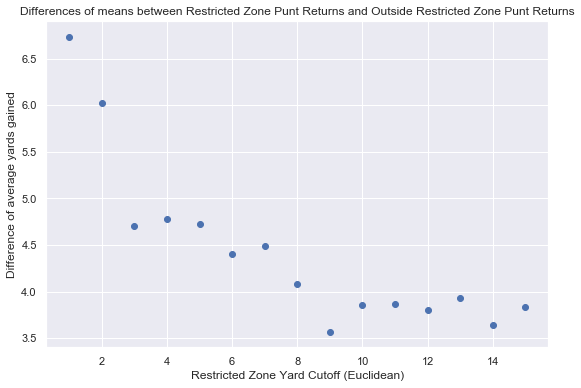

In [112]:
'''Plot of mean differences between the two distributions'''
plt.figure(figsize=(9, 6))
plt.scatter([i for i in range(1, 16)], mean_dif)

plt.title('Differences of means between Restricted Zone Punt Returns and Outside Restricted Zone Punt Returns')
plt.ylabel('Difference of average yards gained', fontsize=12)
plt.xlabel('Restricted Zone Yard Cutoff (Euclidean)', fontsize=12)
plt.savefig('figures/mean_difference.png', bbox_inches='tight')

plt.show()

In [93]:
'''Run to see proximity by yardline distance distributions'''
# # Try proximity_to_PR_circle' or 'proximity_to_PR_x' as the filter
# # Try reward' or 'yardage on play' to see counts of that variable
# mean_dif = distributions_of_interest(yard_and_proximity, 'proximity_to_PR_x', 'yardage on play')

'Run to see proximity by yardline distance distributions'

- Summary
    - **2604** punt returns were analyzed
    - **Average proximity by yardline distance: 9.17 yards**
    - **Average proximity by Euclidean distance: 11.04 yards**
    - Hypothetical Restricted Zones:
        - Given that the closest punt team player is less than or equal to 8 yards (yardline distance) from PR at time of catch:
            - Count: **1216**
            - **Average yards gained by PR on play: 8.01 yards**
            - **Average reward by PR on play: 0.11**
        - Given all punt team players are greater than 8 yards (yardline distance) from PR at time of catch:
            - Count: **1388**
            - **Average yards gained by PR on play: 11.71 yards**
            - **Average reward by PR on play: 0.15**
        - So we are looking at an average difference of 3.70 yards between the two distributions.
        - Given that the closest punt team player is less than or equal to 10 yards (Euclidean distance) from PR at time of catch:
            - Count: **1205**
            - **Average yards gained by PR on play: 7.91 yards**
            - **Average reward by PR on play: 0.11**
        - Given all punt team players are greater than 8 yards (Euclidean distance) from PR at time of catch:
            - Count: **1399**
            - **Average yards gained by PR on play: 11.76 yards**
            - **Average reward by PR on play: 0.16**
        - So we are looking at an average difference of 3.85 yards between the two distributions.
        - I present two hypothetical restricted zone distances to only show that they are nearly equivalent. It's just much easier to know 8 yards by yardline distance then 10 yards by Euclidean distance because of the fields painted yardline markers.
    - **So intuitively the further the closest punt team player is from the PR at the time of the catch, the higher the mean return distance and 'reward' value for return.**

# Links to other notebooks:
- Concussion play analysis with proposed rule changes: https://www.kaggle.com/jdemeo/analysis-concussions
- Analysis of uncalled penalties: https://www.kaggle.com/jdemeo/analysis-uncalled-penalties
- Analysis of fair catches: https://www.kaggle.com/jdemeo/analysis-fair-catches
- Preprocessing of Play Information: https://www.kaggle.com/jdemeo/preprocessing-punt-play
- Preprocessing of NGS data for the above notebooks: https://www.kaggle.com/jdemeo/preprocessing-ngs